In [1]:
#!/usr/bin/env python3

from itertools import product
from collections import deque

import os
import pandas as pd
import glob
import numpy as np

import datetime
from scipy import signal
import pywt

import pyarrow as pa
import pyarrow.parquet as pq
import json

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, os.path.abspath('../../bin/models'))

from nested_xval_utils import *

# Strategy:

Run nested cross validation on unavco gnss dataset.
Limit unavco dataset to comparable events (<70km radius)

for each run, train a model on just gnss data, and then compare the results with the complete model from the NGA dataset
Report Pr, Recall, F1 for these 10 runs.

Then train an overall model on the GNSS data.
Compare with teh overall NGA model against an unseen ambient dataset.

In [2]:
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = fsize-5
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

In [ ]:
#NGA SYNTHETIC DATA
##############
#pq_list=[os.path.join(os.path.dirname(os.getcwd()), 'data/feature_sets/',f) for f in os.listdir(os.path.join(os.path.dirname(os.getcwd()), 'data/feature_sets/'))]
pq_list=os.listdir('../../data/feature_sets/')
pq_list=[os.path.join('../../data/feature_sets/',f) for f in os.listdir('../../data/feature_sets/')]
#pd_list=[pd.read_parquet(pq) for pq in pq_list if ".pq" in pq]
meta_list=[read_meta(pq_fs) for pq_fs in pq_list if ".pq" in pq_fs]
meta_df=pd.DataFrame.from_records(meta_list)


######################
ambient_list= list(meta_df[meta_df.magnitude.isnull()].eq_name.unique())
event_list=meta_df[~meta_df.magnitude.isnull()].sort_values(['magnitude'], ascending=False).groupby("eq_name").count().sort_values(['station'], ascending=False).index.tolist()
full_list=ambient_list+event_list

#convert to rsn
full_list_nga=meta_df[meta_df.eq_name.isin(full_list)].record_number.unique()
event_list_nga=meta_df[meta_df.eq_name.isin(event_list)].record_number.unique()


## JGR GNSS DATA
###############  Generate list of samples by event
#pq_list=[os.path.join(os.path.dirname(os.getcwd()), 'data/feature_set/',f) \
#         for f in  os.listdir(os.path.join(os.path.dirname(os.getcwd()), 'data/feature_set/'))]

pq_list=[os.path.join('../../../snivel/data/feature_set/',f) for f in os.listdir('../../../snivel/data/feature_set/')]
meta_list=[read_meta(pq_fs) for pq_fs in pq_list if ".pq" in pq_fs]
meta_df=pd.DataFrame.from_records(meta_list)

jgr_test=meta_df[(meta_df.radius_from_event<70) | (meta_df.radius_from_event==np.nan)]
jgr_test=meta_df[(meta_df.radius_from_event<70) | (meta_df['radius_from_event'].isna())]




In [17]:
jgr_test

,station,year,doy,lat,long,eventID,radius_from_event,event_time,magnitude,p_arrival,s_arrival,y_label1,y_label2,y_label3
6,p593,2019,185,35.3879,-117.2050,ci38443183,44.437208,2019-07-04T17:33:49.000,6.40,2019-07-04 17:33:56.670000,2019-07-04 17:34:02.230000,"[14, 16, 21]","[7, 5, 0]","[0, 0, 0]"
44,p168,2010,010,40.6686,-123.8815,nc71338066,68.607278,2010-01-10T00:27:39.320,6.50,2010-01-10 00:27:51.120000,2010-01-10 00:27:59.690000,"[16, 16, 17]","[4, 5, 0]","[1, 0, 4]"
49,dssc,2010,188,33.7333,-116.7121,ci10736069,41.401724,2010-07-07T23:53:33.480,5.42,2010-07-07 23:53:40.630000,2010-07-07 23:53:45.820000,"[17, 17, 21]","[3, 3, 0]","[1, 1, 0]"
52,p486,2010,188,33.2602,-116.3223,ci10736069,22.470545,2010-07-07T23:53:33.480,5.42,2010-07-07 23:53:37.360000,2010-07-07 23:53:40.170000,"[17, 17, 17]","[4, 4, 4]","[0, 0, 0]"
64,p464,2019,187,36.1590,-117.4100,ci38457847,37.092392,2019-07-06T04:18:55.790,5.44,2019-07-06 04:19:02.190000,2019-07-06 04:19:06.830000,"[21, 21, 21]","[0, 0, 0]","[0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3203,pmkz,2021,058,NaN,NaN,ambient50,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"
3204,p744,2019,187,NaN,NaN,ambient50,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"
3205,p261,2019,187,NaN,NaN,ambient50,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"
3206,bon2,2017,251,NaN,NaN,ambient50,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"


In [ ]:
# DETERMINE IF AMBIENT IS BEING USED?

In [21]:
event_list_nga

array([212, 4134, 585, ..., 1507, 850, 1517], dtype=object)

# get counts

In [58]:
#from nested_xval_utils import list_to_featurearrays

import importlib
importlib.reload(sys.modules['nested_xval_utils'])
from nested_xval_utils import *

In [33]:
params[0]

{'n_folds': 5,
 'max_depth': 100,
 'n_estimators': 120,
 'class_wt': None,
 'wl_thresh': 0,
 'feature': 'all',
 'stacking': 'horizontal',
 'dims': ['H0', 'H1', 'UP'],
 'augment': True}

In [59]:
X_train_nga, y_train_nga, name_list_nga, times_nga, snr_metric=list_to_featurearrays(event_list_nga, params[0], test=False)

In [6]:
y_train_nga

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
first_t_idx=np.argmax(y_>0)
first_t=times[first_t_idx]

In [12]:
X_, y_, names, times, snr_metric=list_to_featurearrays([100], params[0], test=False)

In [21]:
first_t

3.8

In [13]:
times[np.argmax(y_>0)]

3.8

In [8]:
np.argmax(y_train_nga>0)

6

In [7]:
jgr_test=meta_df[(meta_df.radius_from_event<70) | (meta_df['radius_from_event'].isna())]

In [11]:
#Not ambient ones
jgr_test2=meta_df[~meta_df['radius_from_event'].isna()]

In [14]:
X_train, y_train, name_list, times, snr_metric=list_to_featurearrays_JGR(jgr_test2, params[0], test=True)

In [15]:
X_train.shape

(46778, 546)

In [4]:
jgr_test2=meta_df[meta_df['radius_from_event'].isna()]

In [5]:
jgr_test2

,station,year,doy,lat,long,eventID,radius_from_event,event_time,magnitude,p_arrival,s_arrival,y_label1,y_label2,y_label3
1701,p551,2019,187,NaN,NaN,ambient0,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"
1702,p133,2019,187,NaN,NaN,ambient0,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"
1703,p515,2019,187,NaN,NaN,ambient0,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"
1704,p521,2019,187,NaN,NaN,ambient0,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"
1705,p187,2021,354,NaN,NaN,ambient0,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3203,pmkz,2021,058,NaN,NaN,ambient50,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"
3204,p744,2019,187,NaN,NaN,ambient50,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"
3205,p261,2019,187,NaN,NaN,ambient50,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"
3206,bon2,2017,251,NaN,NaN,ambient50,NaN,NaN,NaN,NaN,NaN,"[59, 59, 59]","[0, 0, 0]","[0, 0, 0]"


# get array dimensions

In [19]:
num_runs=1
outer_results=[]

y_nga_pred=[]
y_nga_test=[]

y_jgr_pred=[]
y_jgr_test=[]
for k in np.arange(num_runs):
    run=k+1
    items = deque(full_list)
    items.rotate(-k)
    test_set=list(items)[::num_runs]
    train_set=list(set(full_list) - set(test_set))
    
    test_set_df=jgr_test[jgr_test.eventID.isin(test_set)]
    train_set_df=jgr_test[jgr_test.eventID.isin(train_set)]
    
    #for features in feature_sets:
    for use_nga in [False]:

        if not use_nga:
            #params=[i | features for i in hyperp]

            #best_est_, stats=grid_search_jgr(train_set, params, X_train_nga, y_train_nga, jgr_test, include_nga=use_nga)
            #threshold=stats.threshold # Hyper Param from xval training
            #best_est_=params[0]
            #stats.threshold=0.4

            X_train, y_train, name_list, times, snr_metric=list_to_featurearrays_JGR(test_set_df, params[0], test=True)


In [21]:
test_set_df

,station,year,doy,lat,long,eventID,radius_from_event,event_time,magnitude,p_arrival,s_arrival,y_label1,y_label2,y_label3
6,p593,2019,185,35.3879,-117.2050,ci38443183,44.437208,2019-07-04T17:33:49.000,6.40,2019-07-04 17:33:56.670000,2019-07-04 17:34:02.230000,"[14, 16, 21]","[7, 5, 0]","[0, 0, 0]"
44,p168,2010,010,40.6686,-123.8815,nc71338066,68.607278,2010-01-10T00:27:39.320,6.50,2010-01-10 00:27:51.120000,2010-01-10 00:27:59.690000,"[16, 16, 17]","[4, 5, 0]","[1, 0, 4]"
49,dssc,2010,188,33.7333,-116.7121,ci10736069,41.401724,2010-07-07T23:53:33.480,5.42,2010-07-07 23:53:40.630000,2010-07-07 23:53:45.820000,"[17, 17, 21]","[3, 3, 0]","[1, 1, 0]"
52,p486,2010,188,33.2602,-116.3223,ci10736069,22.470545,2010-07-07T23:53:33.480,5.42,2010-07-07 23:53:37.360000,2010-07-07 23:53:40.170000,"[17, 17, 17]","[4, 4, 4]","[0, 0, 0]"
64,p464,2019,187,36.1590,-117.4100,ci38457847,37.092392,2019-07-06T04:18:55.790,5.44,2019-07-06 04:19:02.190000,2019-07-06 04:19:06.830000,"[21, 21, 21]","[0, 0, 0]","[0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,p741,2010,188,33.5575,-116.5310,ci10736069,16.404198,2010-07-07T23:53:33.480,5.42,2010-07-07 23:53:36.310000,2010-07-07 23:53:38.370000,"[18, 18, 21]","[3, 3, 0]","[0, 0, 0]"
1685,p636,2021,189,37.9628,-119.1467,nc73584926,67.908277,2021-07-08T22:49:48.110,6.00,2021-07-08 22:49:59.830000,2021-07-08 22:50:08.340000,"[18, 18, 21]","[3, 3, 0]","[0, 0, 0]"
1692,puje,2012,249,10.1140,-85.2725,usp000jrsw,5.655817,2012-09-05T14:42:07.800,7.60,2012-09-05 14:42:08.780000,2012-09-05 14:42:09.480000,"[15, 15, 16]","[6, 6, 5]","[0, 0, 0]"
1697,p228,2007,304,37.6018,-121.6869,nc40204628,20.215260,2007-10-31T03:04:54.810,5.45,2007-10-31 03:04:58.300000,2007-10-31 03:05:00.830000,"[21, 21, 21]","[0, 0, 0]","[0, 0, 0]"


In [20]:
len(X_train)

5187

# back to what i was doing

In [6]:
X_train_nga, y_train_nga, name_list_nga, times_nga, snr_metric=list_to_featurearrays(event_list_nga, params[0], test=False)

In [7]:
#ordered event list to roughly distribute testing 
ambient_list= list(meta_df[meta_df.magnitude.isnull()].eventID.unique())
event_list=jgr_test[~jgr_test.magnitude.isnull()].sort_values(['magnitude'], ascending=False).groupby("eventID").count().sort_values(['station'], ascending=False).index.tolist()
full_list=event_list#+ambient_list
#full_list=event_list

In [8]:
full_list_df=jgr_test[jgr_test.eventID.isin(full_list)]

#X_train_nga, y_train_nga, name_list_nga, times_nga, snr_metric=list_to_featurearrays(full_list_df, params[0], test=False)

In [49]:
len(X_train_nga)

331762

In [5]:
fs={'feature':['all'], 'stacking':['horizontal'], 'dims':[['H0','H1','UP']], 'augment':[True]}
feature_sets=[dict(zip(fs, v)) for v in product(*fs.values())]

d = {'n_folds':[5],'max_depth': [100], 'n_estimators': [120], 'class_wt':[None, 'balanced'],'wl_thresh':[0]}
hyperp=[dict(zip(d, v)) for v in product(*d.values())]

params=[i | feature_sets[0] for i in hyperp]

In [9]:
#for k in np.arange(num_runs):
num_runs=10
outer_results=[]

y_nga_pred=[]
y_nga_test=[]

y_jgr_pred=[]
y_jgr_test=[]
for k in np.arange(10):
    run=k+1
    items = deque(full_list)
    items.rotate(-k)
    test_set=list(items)[::num_runs]
    train_set=list(set(full_list) - set(test_set))
    
    test_set_df=jgr_test[jgr_test.eventID.isin(test_set)]
    train_set_df=jgr_test[jgr_test.eventID.isin(train_set)]
    
    #for features in feature_sets:
    for use_nga in [False,True]:

        if not use_nga:
            #params=[i | features for i in hyperp]

            best_est_, stats=grid_search_jgr(train_set, params, X_train_nga, y_train_nga, jgr_test, include_nga=use_nga)
            threshold=stats.threshold # Hyper Param from xval training
            #best_est_=params[0]
            #stats.threshold=0.4

            X_train, y_train, name_list, times, snr_metric=list_to_featurearrays_JGR(train_set_df, best_est_, test=True)



            clf = RandomForestClassifier(n_estimators=best_est_['n_estimators'], max_depth=best_est_['max_depth'], class_weight=best_est_['class_wt'],random_state=10, n_jobs=-1).fit(X_train, y_train)
        if use_nga:
            threshold=.38
            clf = joblib.load('../../models/synth_model_all_%s.pkl' %int(threshold*100))

        X_test, y_test, name_list, times, snr_metric=list_to_featurearrays_JGR(test_set_df, params[0], test=True)
        #y_pred=clf.predict(X_test)
        y_pred_prob=clf.predict_proba(X_test)[:, 1]

        ### Added

        #threshold=0.5 

        y_pred = (y_pred_prob >= threshold).astype('int')
        ###
        # evaluate the model on test data
        p, r, f1, blah=precision_recall_fscore_support(y_test, y_pred, average='binary')
        print(p,r,f1)

        from sklearn.metrics import precision_recall_curve
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)

        # store the result
        outer_results.append([p,r,f1,threshold, precisions, recalls, thresholds, y_test, y_pred_prob, best_est_, run, best_est_['feature'], test_set, use_nga])
        # report progress
        print('>f1=%.3f' % (f1)) 
        
        if use_nga:
            y_nga_pred.append(y_pred)
            y_nga_test.append(y_test)
        else:
            y_jgr_pred.append(y_pred)
            y_jgr_test.append(y_test)

        #executionTime = (time.time() - startTime)
        #print('Execution time in seconds: ' + str(executionTime))

   max_depth  n_estimators  class_wt  threshold  wl_thresh        f1
1        100           120  balanced   0.418333          0  0.694778
0        100           120      None   0.546667          0  0.685818
0.9736842105263158 0.6244725738396625 0.7609254498714653
>f1=0.761
0.7846715328467153 0.9071729957805907 0.8414872798434443
>f1=0.841
   max_depth  n_estimators  class_wt  threshold  wl_thresh        f1
1        100           120  balanced   0.393333          0  0.739355
0        100           120      None   0.403333          0  0.734608
0.4358974358974359 0.5862068965517241 0.5
>f1=0.500
0.3333333333333333 0.6206896551724138 0.4337349397590361
>f1=0.434
   max_depth  n_estimators  class_wt  threshold  wl_thresh        f1
1        100           120  balanced   0.351667          0  0.760871
0        100           120      None   0.445000          0  0.751190
0.425531914893617 0.8333333333333334 0.5633802816901409
>f1=0.563
0.39622641509433965 0.875 0.5454545454545454
>f1=0.545
   ma

/home/ec2-user/pgv_ml/psuedosyn_gnssvel/bin/models/nested_xval_utils.py:149: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precisions * recalls) / (precisions + recalls)


   max_depth  n_estimators  class_wt  threshold  wl_thresh        f1
0        100           120      None   0.425000          0  0.696967
1        100           120  balanced   0.503333          0  0.581094
0.574468085106383 0.46551724137931033 0.5142857142857143
>f1=0.514
0.7076923076923077 0.7931034482758621 0.7479674796747967
>f1=0.748
   max_depth  n_estimators  class_wt  threshold  wl_thresh        f1
0        100           120      None   0.481667          0  0.748015
1        100           120  balanced   0.343333          0  0.747584
0.8333333333333334 0.37735849056603776 0.5194805194805195
>f1=0.519
0.5660377358490566 0.5660377358490566 0.5660377358490566
>f1=0.566
   max_depth  n_estimators  class_wt  threshold  wl_thresh        f1
1        100           120  balanced   0.305000          0  0.693348
0        100           120      None   0.416667          0  0.689515
0.6147540983606558 0.8928571428571429 0.7281553398058253
>f1=0.728
0.5652173913043478 0.9285714285714286 0.702

/home/ec2-user/pgv_ml/psuedosyn_gnssvel/bin/models/nested_xval_utils.py:149: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precisions * recalls) / (precisions + recalls)


   max_depth  n_estimators  class_wt  threshold  wl_thresh        f1
1        100           120  balanced   0.253333          0  0.663681
0        100           120      None   0.496667          0  0.580987
0.6608695652173913 0.8636363636363636 0.7487684729064039
>f1=0.749
0.5968992248062015 0.875 0.7096774193548386
>f1=0.710


In [14]:
snr_metric.max()

nan

In [10]:
results_df=pd.DataFrame(outer_results, 
                        columns=['precision','recall','f1','threshold', 
                                 'precisions', 'recalls', 'thresholds', 
                                 'y_test', 'y_pred_prob', 'best_est_', 'run', 
                                 'best_est_[feature]', 'test_set', 'use_nga'])

In [11]:
results_df.groupby('use_nga').mean()

/tmp/ipykernel_9354/1864679412.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby('use_nga').mean()


,precision,recall,f1,threshold,run
use_nga,,,,,
False,0.730262,0.628305,0.638577,0.376667,5.5
True,0.625464,0.773473,0.670562,0.380000,5.5


In [ ]:
np.concatenate( y_nga_test, axis=0 )

In [12]:
res_df=[]
for title,y_test, y_pred in zip(['nga','jgr'],[y_nga_test,y_jgr_test],[y_nga_pred, y_jgr_pred]):
    y_test=np.concatenate( y_test, axis=0 )
    y_pred=np.concatenate( y_pred, axis=0 )
    p, r, f1, blah=precision_recall_fscore_support(y_test, y_pred, average='binary')
    print(title,p, r, f1)
    res_df.append([title,p, r, f1])

nga 0.6556862745098039 0.8220255653883972 0.7294938917975567
jgr 0.734533183352081 0.6420845624385447 0.6852046169989506


In [32]:
res_df=pd.DataFrame(res_df, columns=['type','Precision','Recall','F1'])

In [ ]:
res_df.to_parquet('results/jgr_v_nga_table.pq')

In [9]:
res_df=pd.read_parquet('results/jgr_v_nga_table.pq')

In [10]:
X_train_nga=y_train_nga=np.nan

In [ ]:
params[0]

In [11]:
# make overall model of JGR
full_set=jgr_test[jgr_test.eventID.isin(full_list)]

best_est_, stats=grid_search_jgr(full_list, params, X_train_nga, y_train_nga, jgr_test, include_nga=False)
threshold=stats.threshold # Hyper Param from xval training
#best_est_=params[0]
#stats.threshold=0.4

X_train, y_train, name_list, times, snr_metric=list_to_featurearrays_JGR(full_set, best_est_, test=True)

clf = RandomForestClassifier(n_estimators=best_est_['n_estimators'], max_depth=best_est_['max_depth'], class_weight=best_est_['class_wt'],random_state=10, n_jobs=-1).fit(X_train, y_train)
keep_thresh=str(int(100*stats.threshold))
    
joblib.dump(clf, 'results/complete_JGR_model_%s.pkl' %keep_thresh)

   max_depth  n_estimators  class_wt  threshold  wl_thresh        f1
1        100           120  balanced   0.403333          0  0.750409
0        100           120      None   0.470000          0  0.746216


['results/complete_JGR_model_40.pkl']

In [3]:
full_set=jgr_test[jgr_test.eventID.isin(full_list)]

In [4]:
full_set

,station,year,doy,lat,long,eventID,radius_from_event,event_time,magnitude,p_arrival,s_arrival,y_label1,y_label2,y_label3


In [ ]:
X_train, y_train, name_list, times, snr_metric=list_to_featurearrays_JGR(full_set, best_est_, test=True)

In [ ]:
fs_to_Xy(fold, params[2], True)

In [ ]:
# Load in Ambient 2 set data
# test each model - TNR

In [14]:
param=params[0]
X_, y_, name_list, times, snr_metric=list_to_featurearrays_ambient_test(param, test=True)



['/home/ec2-user/pgv_ml/synth_gnss_vel/data/feature_sets_ambient_test/*.pq']


In [15]:
tnr=[]
for ds,clf_n in zip(['nga','jgr'],['synth_model_all_39.pkl','complete_JGR_model_40.pkl']):
    threshold=0.4
    clf = joblib.load('results/'+clf_n)
    y_pred_prob=clf.predict_proba(X_)[:, 1]
    y_pred = (y_pred_prob >= threshold).astype('int')
    
    CM = confusion_matrix(y_, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    FPR = FP/(FP+TN)
   # Specificity or true negative rate
    TNR = TN/(TN+FP)
    
    print(FPR,TNR)
    tnr.append(TNR)

    
    
    

0.014637671025336224 0.9853623289746638
0.013938419224762837 0.9860615807752372


In [17]:
tnr

[0.9853623289746638, 0.9860615807752372]

In [20]:
res_df

,type,Precision,Recall,F1,TNR
0,nga,0.760148,0.720280,0.739677,0.985362
1,jgr,0.720195,0.689977,0.704762,0.986062


In [34]:
res_df['TNR']=tnr

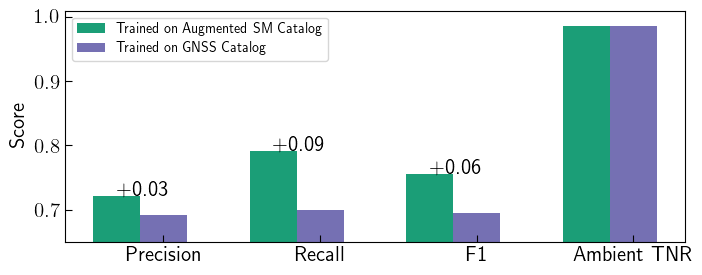

In [66]:
x_labels=['Precision','Recall','F1','Ambient TNR']
colors=['#1b9e77','#7570b3']
ind = np.arange(len(x_labels))  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
rects=[]
for i,(feature,label,color) in enumerate(zip(['nga','jgr'],['Trained on Augmented SM Catalog','Trained on GNSS Catalog'],colors)):
    rects1=ax.bar(ind+width*i, res_df[res_df.type==feature][['Precision','Recall','F1','TNR']].values[0], width, label=label, color=color)
    
ax.set_ylim([0.65,1.01])
ax.set_ylabel('Score')
ax.set_xticks(ind+width)
ax.set_xticklabels( x_labels )

ax.text(ind[0], float(res_df[res_df.type=='nga']['Precision']),'+{0:.2f}'.format(-res_df.Precision.diff()[1]))
ax.text(ind[1], float(res_df[res_df.type=='nga']['Recall']),'+{0:.2f}'.format(-res_df.Recall.diff()[1])) #+width/1.9
ax.text(ind[2], float(res_df[res_df.type=='nga']['F1']),'+{0:.2f}'.format(-res_df.F1.diff()[1]))
#ax.text(ind[3], float(res_df[res_df.type=='nga']['TNR']),'{0:.2f}'.format(res_df.TNR.diff()[1]))

#ax.legend( (rects1[0], rects1[1]), ['nga','jgr'] , ncol=4, title='Features', loc='upper left')
ax.legend()
plt.savefig('figs/why_train_on_sm.png',dpi=300, bbox_inches='tight')

In [17]:
fsize = 20
tsize = 20
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = fsize-3
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

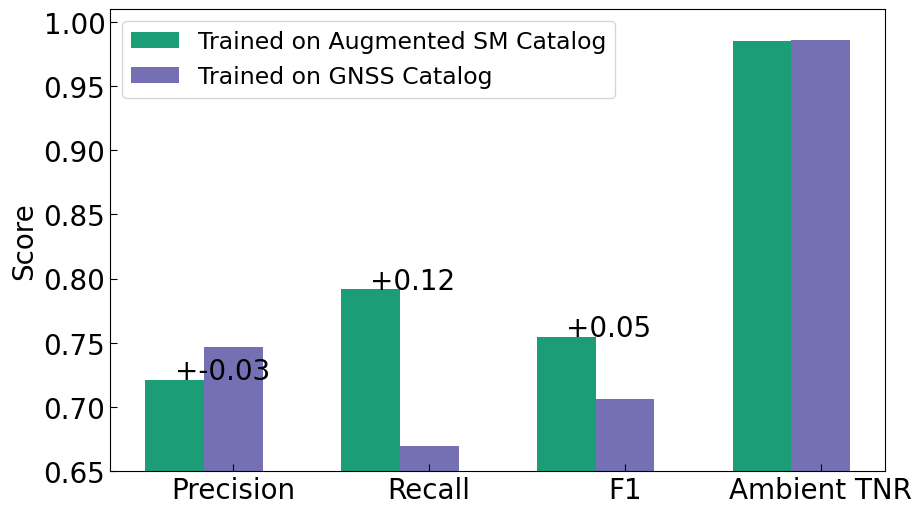

In [35]:
x_labels=['Precision','Recall','F1','Ambient TNR']
colors=['#1b9e77','#7570b3']
ind = np.arange(len(x_labels))  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
rects=[]
for i,(feature,label,color) in enumerate(zip(['nga','jgr'],['Trained on Augmented SM Catalog','Trained on GNSS Catalog'],colors)):
    rects1=ax.bar(ind+width*i, res_df[res_df.type==feature][['Precision','Recall','F1','TNR']].values[0], width, label=label, color=color)
    
ax.set_ylim([0.65,1.01])
ax.set_ylabel('Score')
ax.set_xticks(ind+width)
ax.set_xticklabels( x_labels )

ax.text(ind[0], float(res_df[res_df.type=='nga']['Precision']),'+{0:.2f}'.format(-res_df.Precision.diff()[1]))
ax.text(ind[1], float(res_df[res_df.type=='nga']['Recall']),'+{0:.2f}'.format(-res_df.Recall.diff()[1])) #+width/1.9
ax.text(ind[2], float(res_df[res_df.type=='nga']['F1']),'+{0:.2f}'.format(-res_df.F1.diff()[1]))
#ax.text(ind[3], float(res_df[res_df.type=='nga']['TNR']),'{0:.2f}'.format(res_df.TNR.diff()[1]))

#ax.legend( (rects1[0], rects1[1]), ['nga','jgr'] , ncol=4, title='Features', loc='upper left')
ax.legend()
#plt.savefig('figs/why_train_on_sm.png',dpi=300, bbox_inches='tight')